In [15]:
#download the data
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf 
import datetime 
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
Read_data = True
if Read_data:
    AAPL = pdr.get_data_yahoo('AAPL', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    MSFT = pdr.get_data_yahoo('MSFT', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    NVDA = pdr.get_data_yahoo('NVDA', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    V = pdr.get_data_yahoo('V', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    PYPL = pdr.get_data_yahoo('PYPL', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    MA = pdr.get_data_yahoo('MA', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    ADBE = pdr.get_data_yahoo('ADBE', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    INTC = pdr.get_data_yahoo('INTC', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    CRM = pdr.get_data_yahoo('CRM', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    CSCO = pdr.get_data_yahoo('CSCO', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))

In [16]:
def te_opt(W_Bench, C, obj_te, c_, b_):
    # function that minimize the objective function
    n = len(W_Bench)
    # change the initial guess to help test whether we find the global optimal
    guess = 2
    #W = rand_weights(n) # start with random weights
    if guess==1:
        W = rand_weights(n) # start with random weights
    elif guess==2:
        W = W_Bench # Use Bench weight as initial guess
    else:
        W = 1/n*np.ones([n,1])
    
    optimized = optimize.minimize(obj_te, W, (W_Bench, C), 
                method='SLSQP', constraints=c_, bounds=b_,  
                options={'ftol':1e-8, 'maxiter': 1000000, 'disp': False})

#    optimized = optimize.minimize(obj_te, W, (W_Bench, C), 
#                method='Nelder-Mead', constraints=c_, bounds=b_,  
#                options={'fatol ':1e-10, 'maxiter': 100000, 'disp': False}) 
#    optimized = optimize.minimize(obj_te, W, (W_Bench, C), 
#                method='Powell', constraints=c_, bounds=b_,  
#                options={'ftol':1e-10, 'maxiter': 100000, 'disp': False})  
#    optimized = slsqp_mine.fmin_slsqp(obj_te, W, args=(W_Bench, C), 
#                eqcons=c_[0], ieqcons=c_[1], bounds=b_,  
#                iter=100000, acc=1.0e-6, iprint=1)
#    minimizer_kwargs = {"method": "BFGS"}
#    ret = basinhopping(func, x0, minimizer_kwargs=minimizer_kwargs,  niter=200)        
        
    if not optimized.success: 
        raise BaseException(optimized.message)
    return optimized.x  # Return optimized weights

def opt_min_te(W, C, b_, c_):
    return(te_opt(W, C, obj_te, c_, b_))
    
def opt_min_te_n(W, C, num_repstock, wts_initialGuess, b_, c_):
    return(te_opt_n(W, C, num_repstock, wts_initialGuess, obj_te, c_, b_))
    
def obj_te(W, W_Bench, C): 
    wts_active = W - W_Bench
    #print('wts_active=',wts_active)
    #print('te=',np.sqrt(np.transpose(wts_active)@C@wts_active))
    return(np.sqrt(np.transpose(wts_active)@C@wts_active))


def port_var(W,C): 
     return(np.dot(np.dot(W, C), W))

def port_vol(W,C): 
     return(np.sqrt(port_var(W,C)))
     
def port_ret(W,R): 
    return(np.dot(R,W))
    
    
def obj_var(W, R, C): 
     return(np.dot(np.dot(W, C), W))

# New SX add   
def obj_varminus(W, R, C): 
     return(-np.dot(np.dot(W, C), W))    
    
def obj_ret(W, R, C): 
     return(-port_ret(W,R))
     

#-------------------------------------------------
# EWMA cov 
def ewma_cov(rets, lamda): 
    T, n = rets.shape
    #ret_mat = rets.as_matrix()
    ret_mat = rets.values
    EWMA = np.zeros((T+1,n,n))# corection changed from T to T+1
    S = np.cov(ret_mat.T)  
    EWMA[0,:] = S
    for i in range(1, T+1) :# corection changed from T to T+1
        S = lamda * S  + (1-lamda) * np.matmul(ret_mat[i-1,:].reshape((-1,1)), 
                      ret_mat[i-1,:].reshape((1,-1)))
        EWMA[i,:] = S

    return(EWMA)
    

# create random weights 
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def tracking_error(wts_active,cov):
    TE = np.sqrt(np.transpose(wts_active)@cov@wts_active)
    return TE

# Part1

In [17]:
tickers=['AAPL', 'MSFT', 'NVDA', 'V', 'PYPL', 'MA', 'ADBE', 'INTC', 'CRM','CSCO']

#get the daily return data
ret_data = pd.DataFrame()
for i in tickers:
    d_ = eval(i)
    ret_data[i] = d_['Adj Close']
ret_data = ret_data.pct_change().dropna()
print(ret_data.head())
#split into two subsets
ret_train = ret_data.iloc[0:632,:]
ret_test = ret_data.iloc[632:,:]

                AAPL      MSFT      NVDA         V      PYPL        MA  \
Date                                                                     
2019-04-02  0.014537  0.001428  0.003950  0.003306 -0.003032  0.000879   
2019-04-03  0.006855  0.006544  0.030710  0.004310 -0.005132 -0.001379   
2019-04-04  0.001740 -0.005085 -0.001909 -0.005175 -0.002197 -0.012012   
2019-04-05  0.006694  0.004440  0.014289  0.000063  0.012158  0.002415   
2019-04-08  0.015736  0.000334  0.004399  0.000634  0.007945 -0.000127   

                ADBE      INTC       CRM      CSCO  
Date                                                
2019-04-02 -0.003013 -0.002752 -0.004157  0.005638  
2019-04-03  0.000553  0.020603  0.013146  0.006149  
2019-04-04 -0.013296  0.007931 -0.025212 -0.002533  
2019-04-05 -0.001642 -0.005722  0.000252  0.001270  
2019-04-08  0.005085  0.001439 -0.000568  0.005071  


In [18]:
#Calculate covariance matrix

lamda = 0.94
# vol of the assets 
vols = ret_train.std()
rets_mean = ret_train.mean()
# demean the returns
ret_AllStock = ret_train #- rets_mean
ret_AllStock = ret_AllStock[tickers[0:10]]
# var_ewma calculation of the covraiance using the function from module risk_opt.py
var_ewma = ewma_cov(ret_AllStock, lamda)
#var_ewma_annual = var_ewma*252 #Annualize
# take only the covariance matrix for the last date, which is the forecast for next time period
cov_end = var_ewma[-1,:]
#
cov_end_annual = cov_end*252 #Annualize
std_end_annual = np.sqrt(np.diag(cov_end))*np.sqrt(252)
# calculate the correlation matrix
corr = ret_AllStock.corr()

In [19]:
# tracking error optimization
num_periods, num_stock = ret_AllStock.shape


#
# Test case - Full Replication : minize TE to zero should produce a fund with wts like those of the index
#
# define constraints
b_ = [(0.0,1.0) for i in range(num_stock)]  # no shorting 
c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })   # Sum of active weights = 100%
# calling the optimization function
wts_initial = [0.2145/0.6691,0.2037/0.6691,0.0498/0.6691,0.0395/0.6691,0.0342/0.6691,0.0319/0.6691,0.0280/0.6691,0.0226/0.6691,0.0226/0.6691,0.0223/0.6691]

wts_min_trackingerror = opt_min_te(wts_initial, cov_end, b_, c_)
    # calc TE achieved
wts_active1 = wts_min_trackingerror - wts_initial
TE_optimized = tracking_error(wts_active1,cov_end)
print('\nfull replication TE = {0:.5f} bps'.format(TE_optimized*10000))
print('\nOptimized weights',wts_min_trackingerror)


full replication TE = 0.00000 bps

Optimized weights [0.32057988 0.3044388  0.07442834 0.05903452 0.05111344 0.04767598
 0.04184726 0.03377672 0.03377671 0.03332835]


<Figure size 432x288 with 0 Axes>

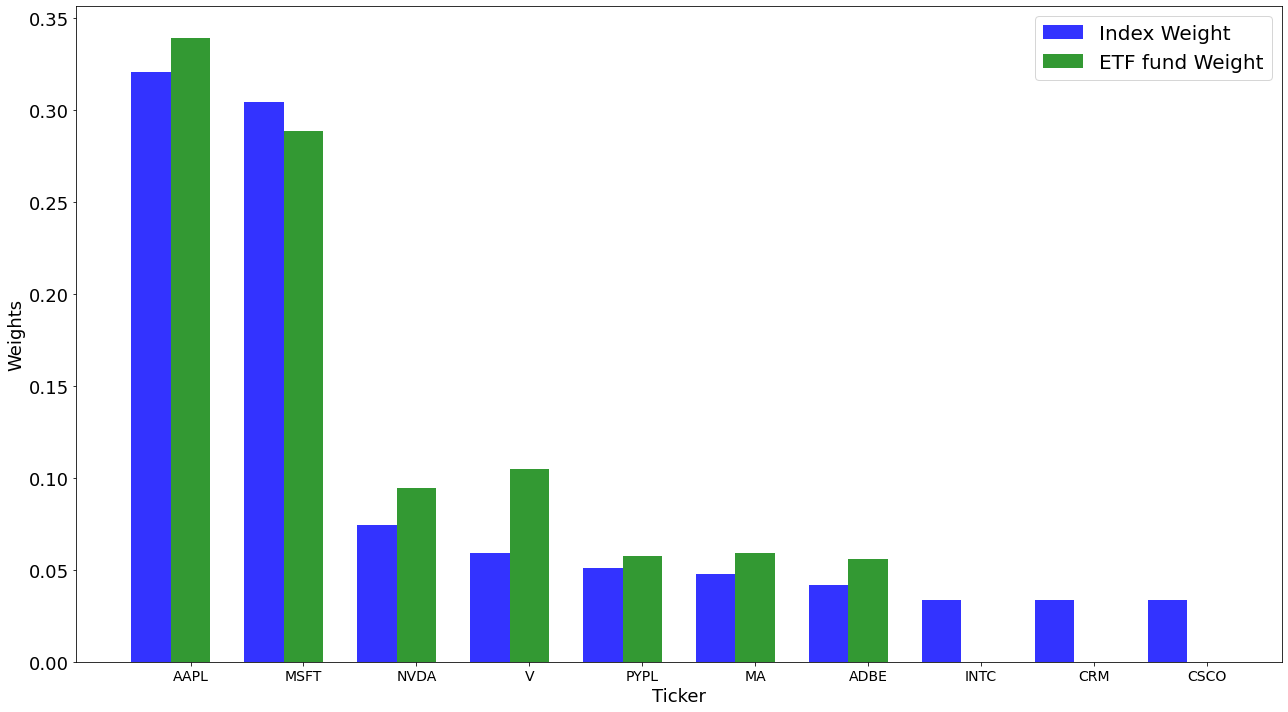

<Figure size 432x288 with 0 Axes>

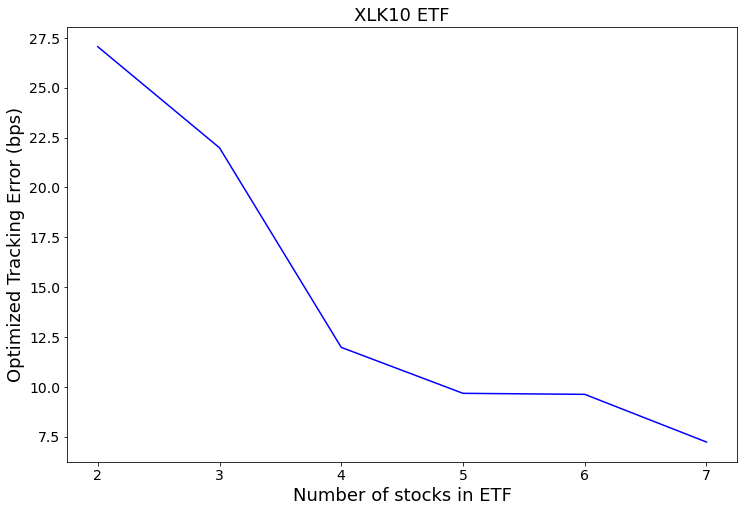

In [20]:
# looping through number of stocks and save the history of TEs
num_stock_b = 2
num_stock_e = 8
numstock_2use = range(num_stock_b,num_stock_e)
wts_active_hist = np.zeros([len(numstock_2use), num_stock])
TE_hist = np.zeros([len(numstock_2use), 1])
count = 0
    
for i in numstock_2use:
    # only the top weight stocks + no shorting 
    b1_c_a_ = [(0.0,1.0) for j in range(i)] 
    # exclude bottom weighted stocks
    b1_c_b_ = [(0.0,0.0000001) for j in range(i,num_stock)] 
    b1_curr_ = b1_c_a_ + b1_c_b_
    wts_min_curr = opt_min_te(wts_initial, cov_end, b1_curr_, c_)
    wts_active_hist[count,:] = wts_min_curr.transpose()
    TE_optimized_c = tracking_error(wts_min_curr-wts_initial,cov_end)
    TE_hist[count,:] = TE_optimized_c*10000# in bps
    count = count+1
        

#  Plot bars of weights
r
figure_count = 1
# ---  create plot of weights fund vs benchmark
plt.figure(figure_count)
figure_count = figure_count+1
fig, ax = plt.subplots(figsize=(18,10))
index = np.arange(len(wts_initial))
bar_width = 0.35
opacity = 0.8
     
rects1 = plt.bar(index, wts_initial, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Index Weight')
     
rects2 = plt.bar(index + bar_width, wts_min_curr, bar_width,
                     alpha=opacity,
                     color='g',
                     label='ETF fund Weight')
     
plt.xlabel('Ticker', fontsize=18)
plt.ylabel('Weights', fontsize=18)
plt.xticks(index + bar_width, (tickers), fontsize=12)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=18)
plt.legend(fontsize=20)
     
plt.tight_layout()
plt.show()
    
    
    #------plot TE as a function of number of stocks -------------
plt.figure(figure_count)
figure_count = figure_count+1
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(range(num_stock_b,num_stock_e), TE_hist, 'b')
plt.xlabel('Number of stocks in ETF', fontsize=18)
plt.ylabel('Optimized Tracking Error (bps)', fontsize=18)
plt.title('XLK10 ETF', fontsize=18)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
    

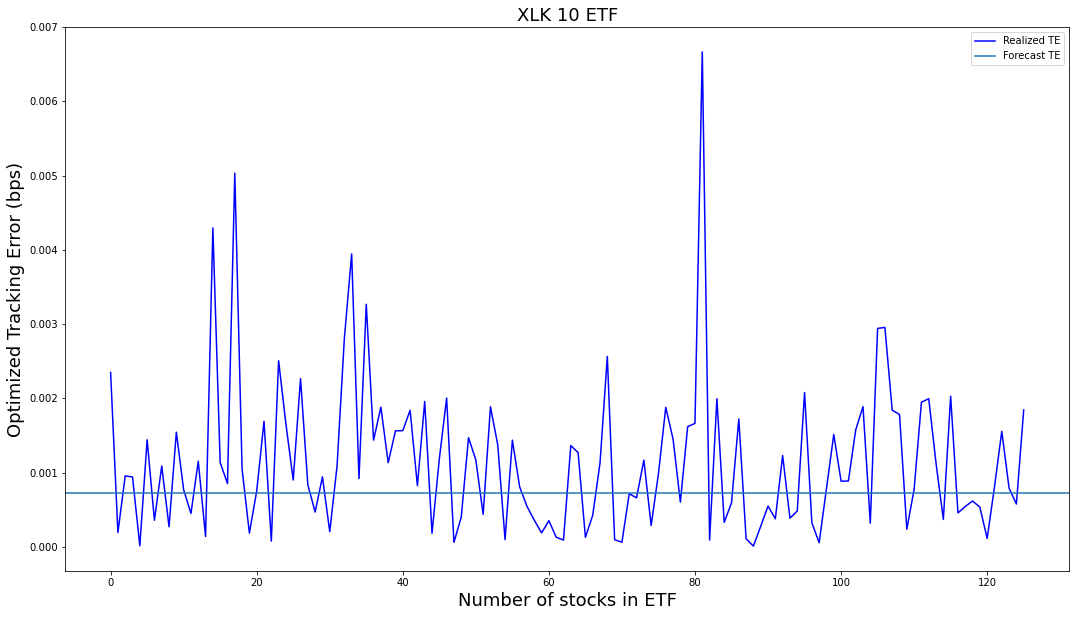

In [21]:
ret_data['XLK10'] = np.dot(ret_data[tickers],wts_initial)

XLK10 = np.dot(ret_test,wts_initial)
ETF = np.dot(ret_test,wts_min_curr)

trackerror_real = ETF-XLK10  # Realized Daily Tracking Error

wts_active = wts_min_curr-wts_initial
te_fore = tracking_error(wts_active,cov_end)
fig, ax = plt.subplots(figsize=(18,10))
plt.plot(range(len(trackerror_real)), abs(trackerror_real), 'b',label='Realized TE')
plt.axhline(te_fore,label='Forecast TE')
plt.xlabel('Number of stocks in ETF', fontsize=18)
plt.ylabel('Optimized Tracking Error (bps)', fontsize=18)
plt.title('XLK 10 ETF', fontsize=18)
plt.legend()

# Part 2

In [22]:
import datetime 
from collections import OrderedDict
from datetime import timedelta
from scipy.optimize import minimize

# risk budgeting approach optimisation object function
def obj_fun(W, cov_assets, risk_budget):
    var_p = np.dot(W.transpose(), np.dot(cov_assets, W))
    sigma_p = np.sqrt(var_p)
    risk_contribution = W*np.dot(cov_assets, W)/sigma_p
    risk_contribution_percent = risk_contribution/sigma_p
    return np.sum((risk_contribution_percent-risk_budget)**2)


# calculate risk budgeting portfolio weight give risk budget
def riskparity_opt(ret_assets, risk_budget, lamda, method='ewma',Wts_min=0.0, leverage=False):
    # number of assets
    num_assets = ret_assets.shape[1]
    # covariance matrix of asset returns
    if method=='ewma':
        cov_assets = cov_ewma(ret_assets, lamda)
    elif method=='ma':
        cov_assets = ret_assets.cov()
    else:
        cov_assets = cov_ewma(ret_assets, lamda)        
    
    # initial weights
    w0 = 1.0 * np.ones((num_assets, 1)) / num_assets
    # constraints
    #cons = ({'type': 'eq', 'fun': cons_sum_weight}, {'type': 'ineq', 'fun': cons_long_only_weight})
    if leverage == True:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-2. }, # Sum of weights = 200%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    else:
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }, # Sum of weights = 100%
              {'type':'ineq', 'fun': lambda W: W-Wts_min}) # weights greater than min wts
    # portfolio optimisation
    return minimize(obj_fun, w0, args=(cov_assets, risk_budget), method='SLSQP', constraints=c_)


In [23]:
tickers=['AAPL', 'CHIQ', 'JPYX', 'EFCAX']
Read_data = True
if Read_data:
        
    AAPL = pdr.get_data_yahoo('AAPL', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    CHIQ = pdr.get_data_yahoo('CHIQ', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    JPYX = pdr.get_data_yahoo('JPY=X', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
    EFCAX = pdr.get_data_yahoo('EFCAX', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))
#get the daily return data
ret_ = pd.DataFrame()
for i in tickers:
    d_ = eval(i)
    ret_[i] = d_['Adj Close']
ret_ = ret_.pct_change().dropna()
ret_demean = ret_-ret_.mean()
num_assets = ret_.shape[1]

In [24]:
#Calculate covariance matrix

lamda = 0.94

# var_ewma calculation of the covraiance using the function from module risk_opt.py
SS = ewma_cov(ret_demean, lamda)
SS1=ewma_cov(ret_,lamda)

#construct risk parity portfolio
# portfolio dates - this defines the first date of portfolio construction
datestr = ret_.index[ret_.index >= '2019-04-01']
    # previous month
mth_previous = datestr[0]
    # initialise portfolio weights matrix
wts = pd.DataFrame(index=datestr, columns=ret_.columns)
    # initialise portfolio return matrix
ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity'])
    # how many rolling calendar days to use for covariance calculation
window = 90
Wts_min = 0.1
risk_budget = 1.0/num_assets*np.ones([1,num_assets]) #risk-party
    #risk_budget = [0.7, 0.3]
leverage = False
varmodel = 'ma'





/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9524: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


sharpe ratio of different strategies:
 risk_parity    [1.2628867912303052]
equal_wted     [1.0991774428796945]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [1.2628867912303052]
AGG                        1.614803
SPY                        0.183411
dtype: object


<Figure size 432x288 with 0 Axes>

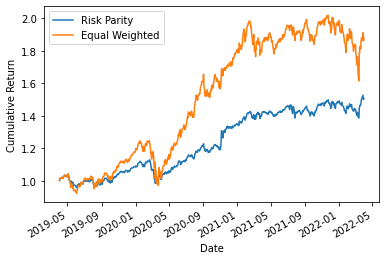

<Figure size 432x288 with 0 Axes>

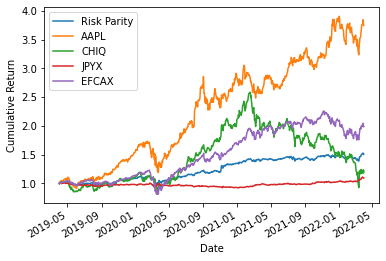

Text(0, 0.5, 'asset weights')

<Figure size 432x288 with 0 Axes>

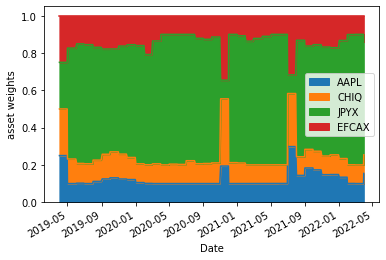

In [25]:
for t in datestr:
# construct risk budgeting portfolio and re-balance on monthly basis
    if t.month==mth_previous:
    # keep the same portfolio weights within the month
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else:
    # update the value of the previous month 
        mth_previous = t.month
    # re-balance the portfolio at the start of the month
            
        t_begin = t - timedelta(days=window)
        ret_used = ret_.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x
    # calculate risk budgeting portfolio returns
    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_.loc[t])
        
# Due to precision issue, wts could be a tiny negative number instead of zero, make them zero
wts[wts<0]=0.0
# Construct equal weighted portfolio
ret_equalwted = pd.DataFrame(np.sum(1.0*ret_[ret_.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
# Construct 60/40 weighted portfolio
#ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
    

# Calculate performance stats
ret_cumu_assets = (ret_ + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()
    
ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets
    
ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP
    
ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt
    
#sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_wted', sharpe_ratio_equalwt.values),
                     )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('AGG', sharpe_ratio_assets[0]),
                     ('SPY', sharpe_ratio_assets[1]),
                     )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)
    
# compare the portfolio cumulative returns
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# compare the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# plot the historical weights of the assets
# area plot showing the weights
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')

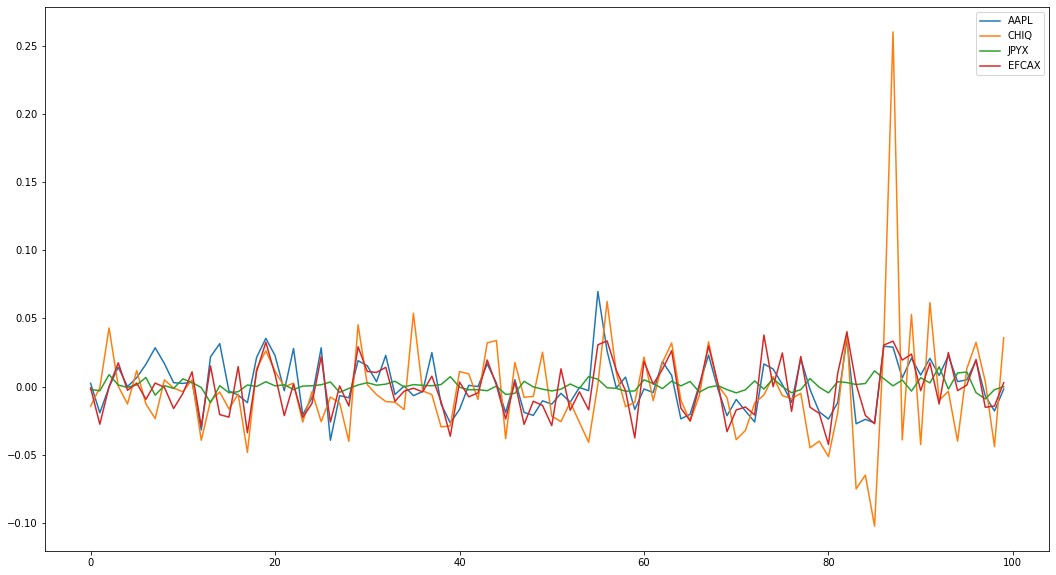

In [26]:
fig, ax = plt.subplots(figsize=(18,10))
plt.plot(range(len(ret_['AAPL'][-100:])),ret_['AAPL'][-100:],label='AAPL')
plt.plot(range(len(ret_['CHIQ'][-100:])),ret_['CHIQ'][-100:],label='CHIQ')
plt.plot(range(len(ret_['JPYX'][-100:])),ret_['JPYX'][-100:],label='JPYX')
plt.plot(range(len(ret_['EFCAX'][-100:])),ret_['EFCAX'][-100:],label='EFCAX')
plt.legend()

In [27]:
ret_train.corr()

,AAPL,MSFT,NVDA,V,PYPL,MA,ADBE,INTC,CRM,CSCO
AAPL,1.000000,0.783563,0.700327,0.633308,0.664780,0.615309,0.707749,0.586046,0.560649,0.604064
MSFT,0.783563,1.000000,0.751492,0.734269,0.740370,0.709976,0.841302,0.645346,0.687905,0.659104
NVDA,0.700327,0.751492,1.000000,0.585903,0.691449,0.564867,0.711512,0.612554,0.576774,0.552839
V,0.633308,0.734269,0.585903,1.000000,0.643683,0.928697,0.646553,0.551703,0.574591,0.639652
PYPL,0.664780,0.740370,0.691449,0.643683,1.000000,0.634337,0.744228,0.535137,0.603814,0.504627
MA,0.615309,0.709976,0.564867,0.928697,0.634337,1.000000,0.613001,0.541125,0.559492,0.619169
ADBE,0.707749,0.841302,0.711512,0.646553,0.744228,0.613001,1.000000,0.587155,0.729982,0.566498
INTC,0.586046,0.645346,0.612554,0.551703,0.535137,0.541125,0.587155,1.000000,0.430221,0.587149
CRM,0.560649,0.687905,0.576774,0.574591,0.603814,0.559492,0.729982,0.430221,1.000000,0.461219
CSCO,0.604064,0.659104,0.552839,0.639652,0.504627,0.619169,0.566498,0.587149,0.461219,1.000000


In [29]:
tickers=['AAPL', 'JPYX','LFST']
Read_data = True
if Read_data:
        
    LFST = pdr.get_data_yahoo('LFST', 
                    start=datetime.datetime(2019, 4, 1), 
                    end=datetime.datetime(2022, 4, 1))

#get the daily return data
ret_ = pd.DataFrame()
for i in tickers:
    d_ = eval(i)
    ret_[i] = d_['Adj Close']
ret_ = ret_.pct_change().dropna()
ret_demean = ret_-ret_.mean()
num_assets = ret_.shape[1]

In [30]:
#Calculate covariance matrix

lamda = 0.94

# var_ewma calculation of the covraiance using the function from module risk_opt.py
SS = ewma_cov(ret_demean, lamda)
SS1=ewma_cov(ret_,lamda)

#construct risk parity portfolio
# portfolio dates - this defines the first date of portfolio construction
datestr = ret_.index[ret_.index >= '2019-04-01']
    # previous month
mth_previous = datestr[0]
    # initialise portfolio weights matrix
wts = pd.DataFrame(index=datestr, columns=ret_.columns)
    # initialise portfolio return matrix
ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity'])
    # how many rolling calendar days to use for covariance calculation
window = 90
Wts_min = 0.1
risk_budget = 1.0/num_assets*np.ones([1,num_assets]) #risk-party
    #risk_budget = [0.7, 0.3]
leverage = False
varmodel = 'ma'

sharpe ratio of different strategies:
 risk_parity      [1.0656340324849922]
equal_wted     [-0.06380024422625144]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [1.0656340324849922]
AGG                        2.001482
SPY                        2.279809
dtype: object


/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9524: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<Figure size 432x288 with 0 Axes>

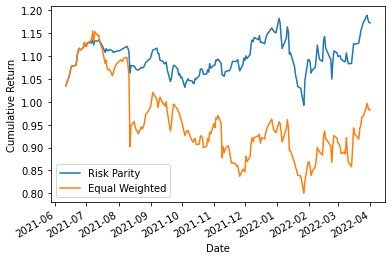

<Figure size 432x288 with 0 Axes>

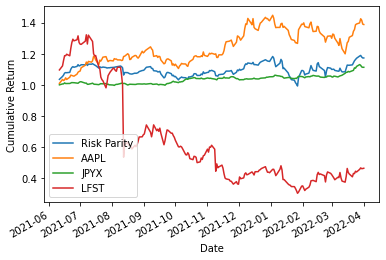

Text(0, 0.5, 'asset weights')

<Figure size 432x288 with 0 Axes>

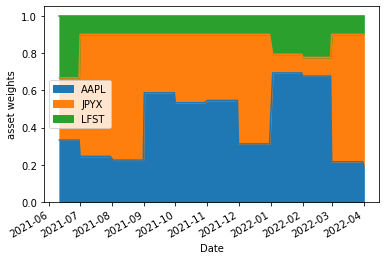

In [31]:
for t in datestr:
# construct risk budgeting portfolio and re-balance on monthly basis
    if t.month==mth_previous:
    # keep the same portfolio weights within the month
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else:
    # update the value of the previous month 
        mth_previous = t.month
    # re-balance the portfolio at the start of the month
            
        t_begin = t - timedelta(days=window)
        ret_used = ret_.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x
    # calculate risk budgeting portfolio returns
    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_.loc[t])
        
# Due to precision issue, wts could be a tiny negative number instead of zero, make them zero
wts[wts<0]=0.0
# Construct equal weighted portfolio
ret_equalwted = pd.DataFrame(np.sum(1.0*ret_[ret_.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
# Construct 60/40 weighted portfolio
#ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
    

# Calculate performance stats
ret_cumu_assets = (ret_ + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()
    
ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets
    
ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP
    
ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt
    
#sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_wted', sharpe_ratio_equalwt.values),
                     )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('AGG', sharpe_ratio_assets[0]),
                     ('SPY', sharpe_ratio_assets[1]),
                     )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)
    
# compare the portfolio cumulative returns
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# compare the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# plot the historical weights of the assets
# area plot showing the weights
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')

## After Leverage

In [32]:
#Calculate covariance matrix

lamda = 0.94

# var_ewma calculation of the covraiance using the function from module risk_opt.py
SS = ewma_cov(ret_demean, lamda)
SS1=ewma_cov(ret_,lamda)

#construct risk parity portfolio
# portfolio dates - this defines the first date of portfolio construction
datestr = ret_.index[ret_.index >= '2019-04-01']
    # previous month
mth_previous = datestr[0]
    # initialise portfolio weights matrix
wts = pd.DataFrame(index=datestr, columns=ret_.columns)
    # initialise portfolio return matrix
ret_riskParity = pd.DataFrame(index=datestr, columns=['Risk Parity'])
    # how many rolling calendar days to use for covariance calculation
window = 90
Wts_min = 0.1
risk_budget = 1.0/num_assets*np.ones([1,num_assets]) #risk-party
    #risk_budget = [0.7, 0.3]
leverage = True
varmodel = 'ma'

/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:9524: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/huiqiongwu/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


sharpe ratio of different strategies:
 risk_parity      [0.7048854203067958]
equal_wted     [-0.06380024422625144]
dtype: object

sharpe ratio of strategies vs assets:
 risk_parity    [0.7048854203067958]
AGG                        2.001482
SPY                        2.279809
dtype: object


<Figure size 432x288 with 0 Axes>

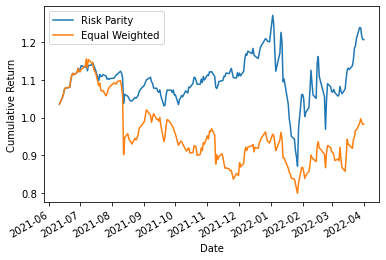

<Figure size 432x288 with 0 Axes>

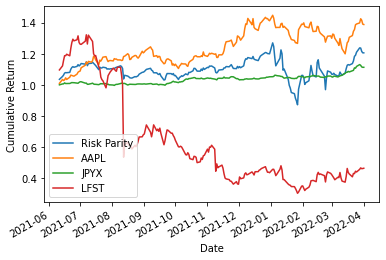

Text(0, 0.5, 'asset weights')

<Figure size 432x288 with 0 Axes>

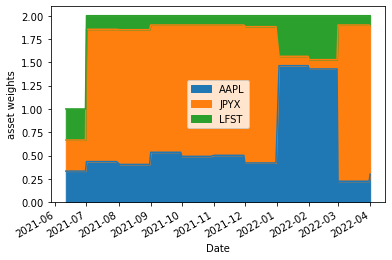

In [33]:
for t in datestr:
# construct risk budgeting portfolio and re-balance on monthly basis
    if t.month==mth_previous:
    # keep the same portfolio weights within the month
        wts.loc[t] = wts.iloc[wts.index.get_loc(t)-1]
    else:
    # update the value of the previous month 
        mth_previous = t.month
    # re-balance the portfolio at the start of the month
            
        t_begin = t - timedelta(days=window)
        ret_used = ret_.loc[t_begin:t,:]
        wts.loc[t] = riskparity_opt(ret_used, risk_budget, lamda, varmodel, Wts_min, leverage).x
    # calculate risk budgeting portfolio returns
    ret_riskParity.loc[t] = np.sum(wts.loc[t] * ret_.loc[t])
        
# Due to precision issue, wts could be a tiny negative number instead of zero, make them zero
wts[wts<0]=0.0
# Construct equal weighted portfolio
ret_equalwted = pd.DataFrame(np.sum(1.0*ret_[ret_.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
# Construct 60/40 weighted portfolio
#ret_equalwted = pd.DataFrame(np.sum(1.0*ret_assets[ret_assets.index>=datestr[0]]/num_assets, axis=1), columns=['Equal Weighted'])
    

# Calculate performance stats
ret_cumu_assets = (ret_ + 1).cumprod()
ret_cumu_riskP = (ret_riskParity + 1).cumprod()
ret_cumu_equalwt = (ret_equalwted + 1).cumprod()
    
ret_annual_assets = ret_cumu_assets.iloc[-1]**(250/len(ret_cumu_assets))-1
std_annual_assets = ret_.std()*np.sqrt(250)
sharpe_ratio_assets = ret_annual_assets/std_annual_assets
    
ret_annual_riskP = ret_cumu_riskP.iloc[-1]**(250/len(ret_cumu_riskP))-1
std_annual_riskP = ret_riskParity.std()*np.sqrt(250)
sharpe_ratio_riskP = ret_annual_riskP/std_annual_riskP
    
ret_annual_equalwt = ret_cumu_equalwt.iloc[-1]**(250/len(ret_cumu_equalwt))-1
std_annual_equalwt = ret_equalwted.std()*np.sqrt(250)
sharpe_ratio_equalwt = ret_annual_equalwt/std_annual_equalwt
    
#sharpe_table = [sharpe_ratio_riskP, sharpe_ratio_equalwt]
sharpe_table = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('equal_wted', sharpe_ratio_equalwt.values),
                     )))
sharpe_table1 = pd.Series(OrderedDict((('risk_parity', sharpe_ratio_riskP.values),
                     ('AGG', sharpe_ratio_assets[0]),
                     ('SPY', sharpe_ratio_assets[1]),
                     )))
print('sharpe ratio of different strategies:\n',sharpe_table)
print('\nsharpe ratio of strategies vs assets:\n',sharpe_table1)
    
# compare the portfolio cumulative returns
figure_count = 1
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_equalwt], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# compare the portfolio cumulative returns vs. asset returns
plt.figure(figure_count)
figure_count = figure_count+1
pd.concat([ret_cumu_riskP, ret_cumu_assets], axis=1).plot()
plt.ylabel('Cumulative Return')
plt.show()
    
# plot the historical weights of the assets
# area plot showing the weights
plt.figure(figure_count)
figure_count = figure_count + 1
wts.plot.area()
plt.ylabel('asset weights')